## This script contains the following:

### 1. Importing your libraries and data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the Zillow Real Estate Data

### 1. Importing libraries and data

In [3]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [4]:
# Importing the Zillow Real Estate Data 

# Data Source: Zillow Data from Nasdaq Data Link
 
# For the purpose of this case study, we need to filter the data to include all zipcodes within King County, WA.

path =  '/Users/swapnilgadage/Documents/DataAnalytics/Achivment 6'

data = pd.read_csv(os.path.join(path, 'Data', 'Original Data', 'ZILLOW_DATA.csv'))
regions = pd.read_csv(os.path.join(path, 'Data', 'Original Data', 'ZILLOW_REGIONS.csv'))

In [5]:
data.head()

,indicator_id,region_id,date,value
0,Z4BR,65856,2018-02-28,509966.717868
1,Z4BR,94920,2018-02-28,393052.284119
2,Z4BR,63078,2018-02-28,89932.390841
3,Z4BR,73108,2018-02-28,219385.968716
4,Z4BR,77740,2018-02-28,218395.779920


In [6]:
data.shape

(155574532, 4)

In [7]:
regions.head()

,region_id,region_type,region
0,394415,metro,"Bridgeport, CT"
1,394653,metro,"Greenville, SC"
2,394312,metro,"Albuquerque, NM"
3,394357,metro,"Bakersfield, CA"
4,394308,metro,"Albany, NY"


### 2. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Create a subset from region data filtered to only show regions based on zip code
regions_zip = regions.loc[(regions['region_type'] == 'zip')]

In [11]:
regions_zip.head()

,region_id,region_type,region
154,58011,zip,00612; MI; Crawford County; Frederic
817,58051,zip,00693; PA; Pittsburgh; Westmoreland County; Gr...
1755,58109,zip,00795; AL; Auburn-Opelika; Lee County; Juana Diaz
2737,62046,zip,"11236;NY;New York-Newark-Jersey City, NY-NJ-PA..."
2738,61807,zip,"10467;NY;New York-Newark-Jersey City, NY-NJ-PA..."


In [12]:
# List of desired ZIP codes
zip_codes = [98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 
             98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029, 98030, 98031,
             98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045, 98047, 98051,
             98052, 98053, 98055, 98056, 98057, 98058, 98059, 98065, 98070, 98072,
             98074, 98075, 98077, 98092, 98101, 98102, 98103, 98104, 98105, 98106, 
             98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98121,
             98122, 98125, 98126, 98131, 98133, 98134, 98136, 98144, 98146, 98148, 
             98154, 98155, 98158, 98161, 98164, 98166, 98168, 98174, 98177, 98178, 
             98188, 98198, 98199, 98251, 98354, 98422]

In [13]:
# Zipcode is currently embedded as part of a string in the 'region' column. 
# We need to extract the zipcode and create a new column.

# Function to extract ZIP code if it's valid from the 'region' column
def extract_zip(region_str):
    first_part = region_str.split(';')[0]  # Split by ';' and take the first part
    if first_part.isdigit():  # Check if the first part is a number
        return int(first_part)
    return None  # Return None if it's not a ZIP code

# Apply the function to create a new 'zip_code' column
regions_zip['zip_code'] = regions_zip['region'].apply(extract_zip)

In [14]:
# Filter by desired ZIP codes
filtered_zip = regions_zip[regions_zip['zip_code'].isin(zip_codes)]

# Print the filtered dataframe
filtered_zip.head()

,region_id,region_type,region,zip_code
42647,99534,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
43536,99565,zip,"98105;WA;Seattle-Tacoma-Bellevue, WA;Seattle;K...",98105
43549,99559,zip,"98092;WA;Seattle-Tacoma-Bellevue, WA;nan;King ...",98092
43578,99575,zip,"98115;WA;Seattle-Tacoma-Bellevue, WA;Seattle;K...",98115
43583,99508,zip,"98023;WA;Seattle-Tacoma-Bellevue, WA;Federal W...",98023


In [15]:
# Merge the 'filtered_zip' dataframe on 'data'
df_merged = data.merge(filtered_zip, on = 'region_id', how = 'inner')

In [16]:
df_merged.head()

,indicator_id,region_id,date,value,region_type,region,zip_code
0,Z4BR,99502,2018-02-28,717732.216835,zip,"98014;WA;Seattle-Tacoma-Bellevue, WA;Carnation...",98014
1,Z4BR,99741,2018-02-28,405107.137256,zip,"98354;WA;Seattle-Tacoma-Bellevue, WA;Milton;Pi...",98354
2,Z4BR,99533,2018-02-28,721160.698773,zip,"98051;WA;Seattle-Tacoma-Bellevue, WA;Ravensdal...",98051
3,Z4BR,99498,2018-02-28,532375.955907,zip,"98010;WA;Seattle-Tacoma-Bellevue, WA;Black Dia...",98010
4,Z4BR,99509,2018-02-28,872770.026714,zip,"98024;WA;Seattle-Tacoma-Bellevue, WA;Fall City...",98024


In [17]:
df_merged['indicator_id'].value_counts()

indicator_id
ZALL    27639
Z2BR    27384
ZSFH    27312
Z3BR    27236
Z4BR    26324
Z5BR    25896
Z1BR    25116
ZCON    24722
RSNA     5398
RSSA     5398
Name: count, dtype: int64

In [18]:
# Create subset including records where indicator_id == 'ZALL' 
# 'ZALL' represents the "house price for All Homes (SFR, Condo/Co-op)"

df_merged2 = df_merged.loc[(df_merged['indicator_id'] == 'ZALL')]

In [19]:
df_merged2.head()

,indicator_id,region_id,date,value,region_type,region,zip_code
20602,ZALL,99534,1996-01-31,210783.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
20603,ZALL,99534,1996-02-29,210840.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
20604,ZALL,99534,1996-03-31,210858.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
20605,ZALL,99534,1996-04-30,210898.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052
20606,ZALL,99534,1996-05-31,210905.0,zip,"98052;WA;Seattle-Tacoma-Bellevue, WA;Redmond;K...",98052


####  Data Cleaning

In [21]:
df_merged2.dtypes

indicator_id     object
region_id         int64
date             object
value           float64
region_type      object
region           object
zip_code          int64
dtype: object

In [22]:
# Convert 'date' to datetime format
df_merged2['date'] = pd.to_datetime(df_merged2['date'])

In [23]:
# Check for duplicates
dups = df_merged2[df_merged2.duplicated()]

print(dups)

Empty DataFrame
Columns: [indicator_id, region_id, date, value, region_type, region, zip_code]
Index: []


There are no duplicates.

In [25]:
# Check for missing values
df_merged2.isnull().sum()

indicator_id    0
region_id       0
date            0
value           0
region_type     0
region          0
zip_code        0
dtype: int64

There are no missing values. 

In [27]:
# Check for mixed-type data
for col in df_merged2.columns.tolist():
  weird = (df_merged2[[col]].map(type) != df_merged2[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (df_merged2[weird]) > 0:
    print (col)

There is no mixed-type data. 

In [29]:
df_merged2.dtypes

indicator_id            object
region_id                int64
date            datetime64[ns]
value                  float64
region_type             object
region                  object
zip_code                 int64
dtype: object

In [30]:
# Group by 'date' and calculate the mean value for each date
king_county_prices = df_merged2.groupby('date')['value'].mean().reset_index()

In [31]:
king_county_prices.head()

,date,value
0,1996-01-31,194879.2375
1,1996-02-29,195006.4250
2,1996-03-31,195032.7625
3,1996-04-30,195043.1500
4,1996-05-31,195009.4625


In [32]:
king_county_prices.describe()

,date,value
count,343,3.430000e+02
mean,2010-04-30 22:15:02.623906816,4.799890e+05
min,1996-01-31 00:00:00,1.948792e+05
25%,2003-03-15 12:00:00,3.237790e+05
50%,2010-04-30 00:00:00,4.197601e+05
75%,2017-06-15 00:00:00,6.022647e+05
max,2024-07-31 00:00:00,1.039218e+06
std,NaN,2.156446e+05


In [33]:
# Set the "Date" column as the index

from datetime import datetime

king_county_prices['datetime'] = pd.to_datetime(king_county_prices['date']) # Create a datetime column from "date"
king_county_prices = king_county_prices.set_index('datetime') # Set the datetime as the index of the dataframe
king_county_prices.drop(['date'], axis=1, inplace=True) # Drop the "date" column
king_county_prices.head()

,value
datetime,
1996-01-31,194879.2375
1996-02-29,195006.4250
1996-03-31,195032.7625
1996-04-30,195043.1500
1996-05-31,195009.4625


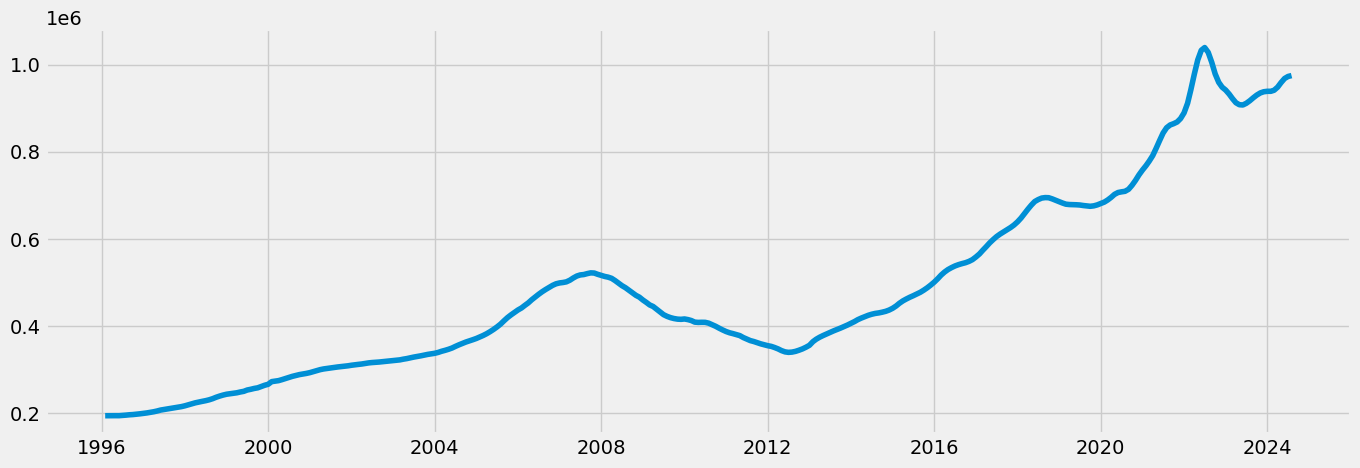

In [34]:
# Plot the data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(king_county_prices)

The imported dataset included various indicators and regions, such as zip codes, cities, states, and neighborhoods. I selected the indicator 'ZALL,' which represents the median house price for "All Homes (SFR, Condo/Co-op)." My analysis focuses on house price trends in King County, WA, so I filtered the data to include only the zip codes within King County, along with the selected indicator. Then, I grouped the data by date to calculate the average house price across King County over time.

### 3. Time-series analysis: decomposition

In [37]:
# Decompose the data's components
decomposition = sm.tsa.seasonal_decompose(king_county_prices, model='additive')

In [38]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

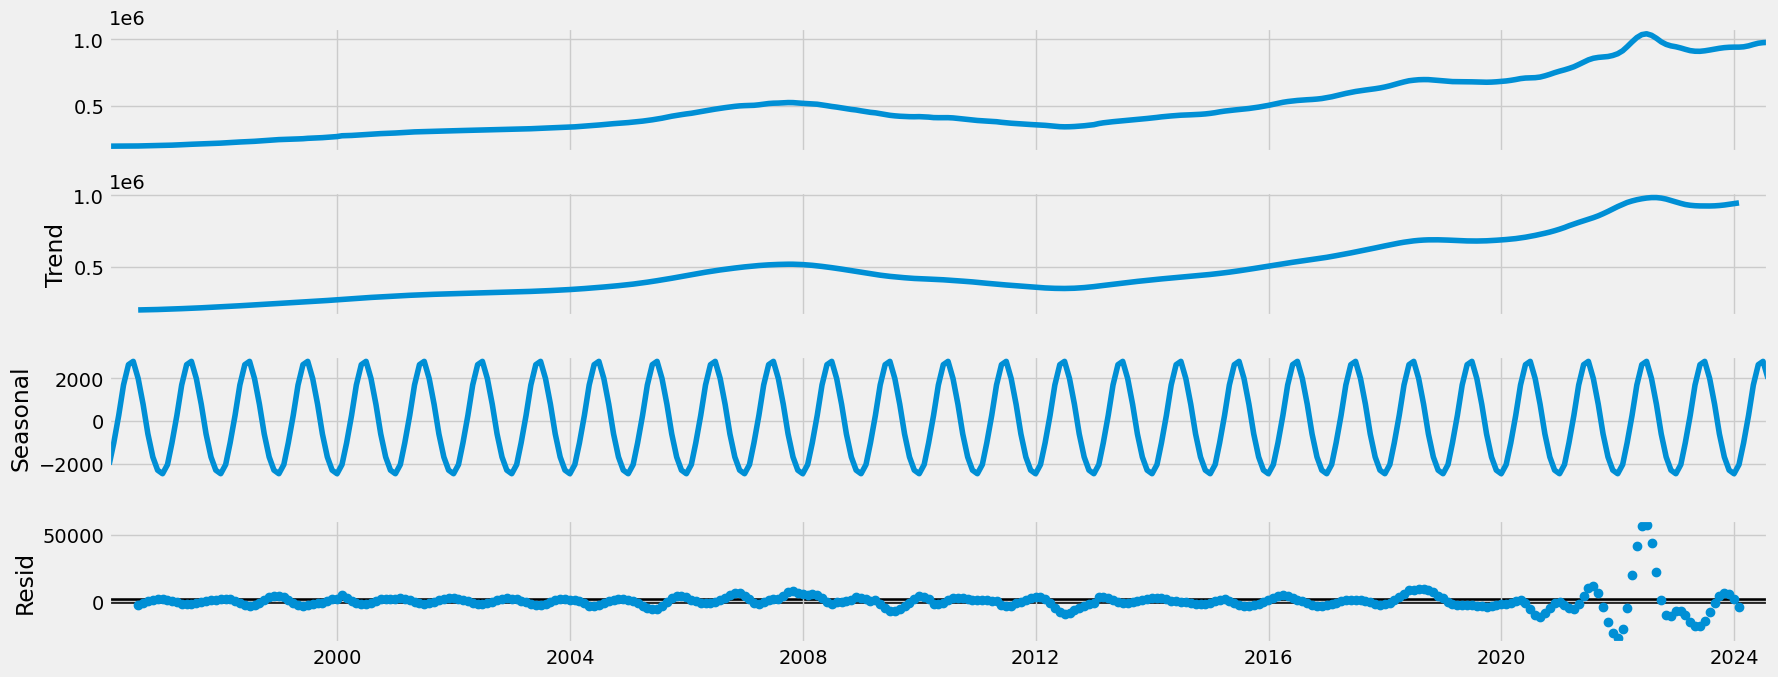

In [39]:
# Plot the separated components

decomposition.plot()
plt.show()

**Insights:**

- The first chart is the **level**. This is just the data itself including all its components. 

- The second chart is the **trend**. There is a gradual increase over time. The trend line compared to the level are very similar.

- The third chart is the **seasonality**. There is seasonality in this data.

- The 4th chart is the **noise** or **"residual'**. There isn't much unexplained noise except for the fluctuations between 2020-2024 likely influenced by the impact of COVID-19 on the real estate market. 

Given the presence of both an upward **trend** and **seasonality**, this data is considered non-stationary. We will conduct a statistical test to confirm this.

### 4. Testing for stationarity

In [42]:
# Conduct a Dickey-Fuller test to check for stationarity

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): 
    print('Dickey-Fuller Stationarity Test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print(result)

# Apply the test on the time series
dickey_fuller(king_county_prices['value'])

Dickey-Fuller Stationarity Test:
Test Statistic                   0.445619
p-value                          0.983123
Number of Lags Used              5.000000
Number of Observations Used    337.000000
Critical Value (1%)             -3.449904
Critical Value (5%)             -2.870155
Critical Value (10%)            -2.571360
dtype: float64


Null hypothesis: the presence of a root unit.

Alternative hypothesis: there is no root unit (root unit is any jump that can't be explained by variation)

The test statistic is greater than the critical values at the 1%, 5%, and 10% levels. Since the test statistic exceeds these critical values, we cannot reject the null hypothesis. This indicates that there is a unit root in the data, confirming that it is non-stationary.

### 5. Stationarizing the Zillow Real Estate Data

In [46]:
# Stationarize the data by using the differencing technique
data_diff = king_county_prices - king_county_prices.shift(1)

# Remove any mising values as a result of the differencing
data_diff.dropna(inplace=True)

In [47]:
data_diff.head()

,value
datetime,
1996-02-29,127.1875
1996-03-31,26.3375
1996-04-30,10.3875
1996-05-31,-33.6875
1996-06-30,575.5625


In [48]:
data_diff.columns

Index(['value'], dtype='object')

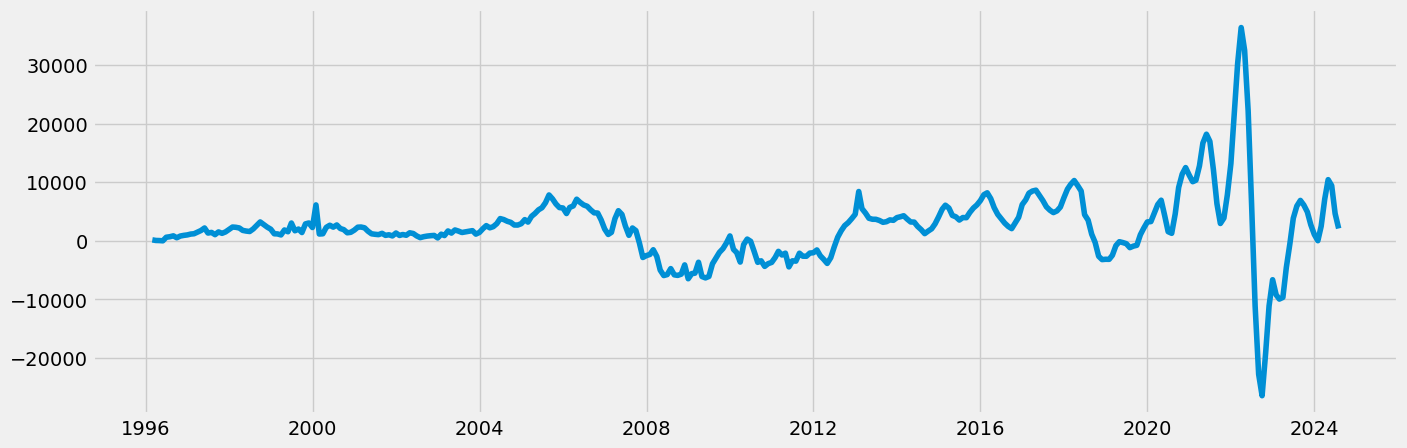

In [49]:
# Plot the time series to see what the effect of the differencing
plt.figure(figsize=(15,5), dpi = 100)
plt.plot(data_diff)

In [50]:
# Recheck for stationarity by running another Dickey_Fuller test
dickey_fuller(data_diff['value'])

Dickey-Fuller Stationarity Test:
Test Statistic                  -4.874072
p-value                          0.000039
Number of Lags Used              4.000000
Number of Observations Used    337.000000
Critical Value (1%)             -3.449904
Critical Value (5%)             -2.870155
Critical Value (10%)            -2.571360
dtype: float64


The test statistic is smaller than the critical value (10%) and a satisfactory p-value of <0.05, indicating there is no root unit and the series is stationary. 

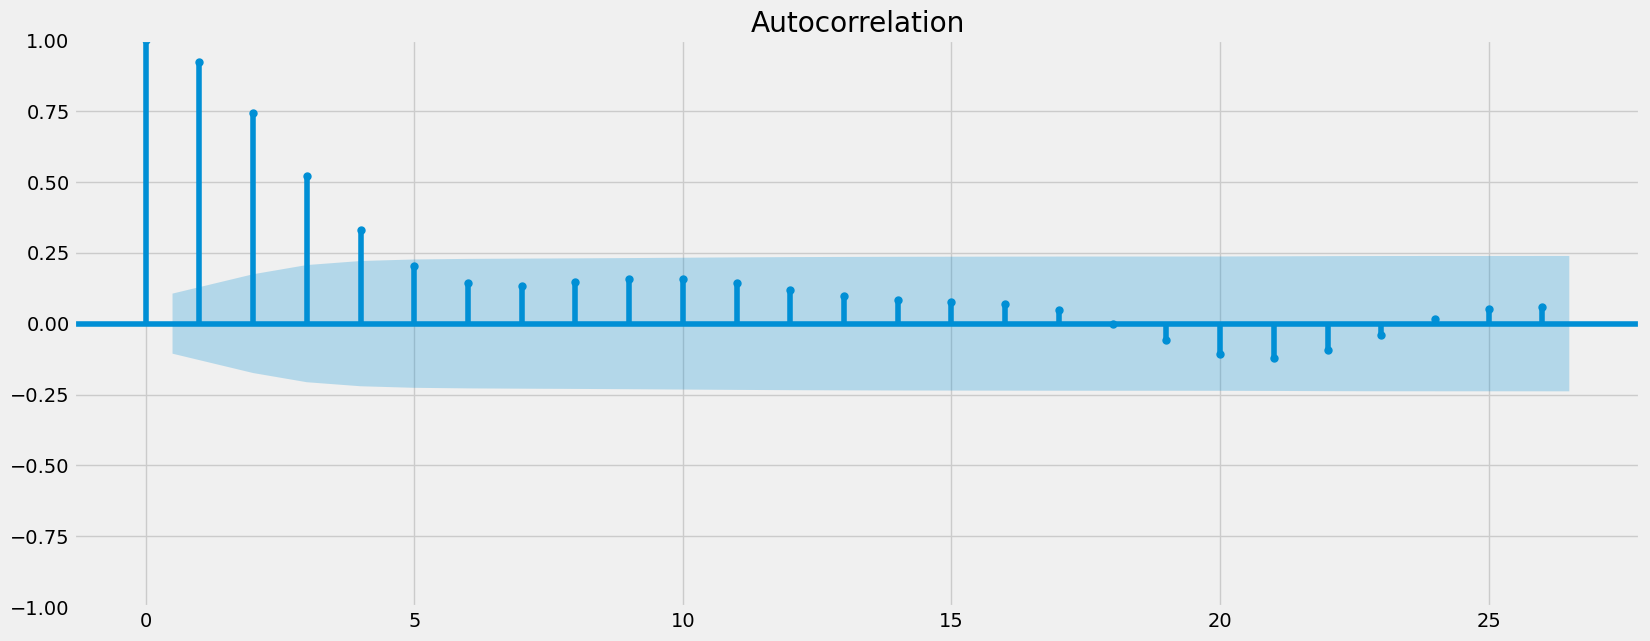

In [52]:
# Check the data's autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_diff)
plt.show()